In [1]:
import numpy as np
import time
from numpy import *
from scipy import io

import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sys
sys.path.append("../")

from spline import splineBasis
from ado import * 

from pysindy.differentiation import SmoothedFiniteDifference

# Physics-informed Spline Learning

read data and build cubic B-spline model 

In [2]:
q_m = io.loadmat('../systems/EMPS/DATA_EMPS.mat')['qm'].reshape(-1, 1)[1000:11001, :]
tau_m = (io.loadmat('../systems/EMPS/DATA_EMPS.mat')['vir'])[1000:11001, :]
t_m = np.around(io.loadmat('../systems/EMPS/DATA_EMPS.mat')['t'], decimals=5, out=None).flatten()[1000:11001]


start_t = 1
end_t = 11
num_control = 200*(end_t-start_t)+1
num_c = 5000*(end_t-start_t)+1

t = np.linspace(start_t, end_t, num_control)
knots = np.array([start_t,start_t,start_t] + list(t) + [end_t,end_t,end_t])

t_c = t_m

basis = splineBasis(knots, t_m, t_c)
basis_m, basis_dt_m = basis.get_measurement()
basis_c, basis_dt_c = basis.get_collocation()

pre-training

In [3]:
self_library = ['1', 'p', 'q', 'p**2', 'q**2', 'torch.sign(p)', 'tau']

# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
t_c_len = basis_c.shape[0]
num_control = basis_m.shape[1]
num_term = len(self_library)

# create a function that will be evaluated while training 
# this function is constructed with unknown parameters {cxi, cyi, czi}, i=0,1,....num_terms
function_dp = ''

for i in range(num_term):
    term = self_library[i]
    function_dp += ('+c'+str(i)+'*'+term)
function_dp = function_dp[1:]
    
# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_c = torch.Tensor(basis_c).to(device)
N_dt = torch.Tensor(basis_dt_c).to(device)

# convert the measurement data into tensor 
q_measurement = torch.Tensor(q_m.flatten()).to(device)
tau_measurement = torch.Tensor(tau_m.flatten()).to(device)

# define control points (one column for each variable)
P = torch.autograd.Variable(torch.rand(num_control, 2).to(device), requires_grad=True)

for i in range(num_term): globals()['c'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
coef_lst = [globals()['c'+str(i)] for i in range(num_term)]


# physics loss (denominator values known, calculate in the measurement domain)
def loss_phy(P):
    q = torch.matmul(N_c, P[:, 0])
    p = torch.matmul(N_c, P[:, 1])
    tau = tau_measurement
    return (torch.norm(torch.matmul(N_dt, P[:, 0]) - p, p=2) ** 2 +
            0.01 * torch.norm(torch.matmul(N_dt, P[:, 1]) - eval(function_dp), p=2) ** 2) / t_c_len   

# data loss + physics loss
def loss_total(P):
    loss_p = loss_phy(P)
    loss_d = torch.norm(torch.matmul(N, P)[:, 0] - q_measurement, p=2) ** 2 / t_m_len
    
    lossd_his.append(float(loss_d.cpu().detach().numpy()))
    lossp_his.append(float(loss_p.cpu().detach().numpy()))
    
    return loss_d + loss_p

start_time = time.time()
    
# define learning rate and optimizer 
learning_rate = 0.01
optimizer = torch.optim.Adamax([P] + coef_lst, lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

lossd_his = []
lossp_his = []


for t in range(200000):
    optimizer.zero_grad()

    loss = loss_total(P)
    loss.backward()

    scheduler.step(loss)
    
    optimizer.step()

    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0

    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 199999:
        print("200,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))


Using device: cuda

epoch : 0 loss : 2225.645263671875 lr : 0.01
epoch : 5000 loss : 0.08469756692647934 lr : 0.01
epoch : 10000 loss : 9.253663301933557e-05 lr : 0.001
epoch : 15000 loss : 3.1977115213521756e-06 lr : 0.0001
epoch : 20000 loss : 2.6707305096351774e-06 lr : 1e-05
Early stopping!
epoch : 20422 loss : 2.669069317562389e-06 lr : 1e-05
--- 82.65650653839111 seconds ---


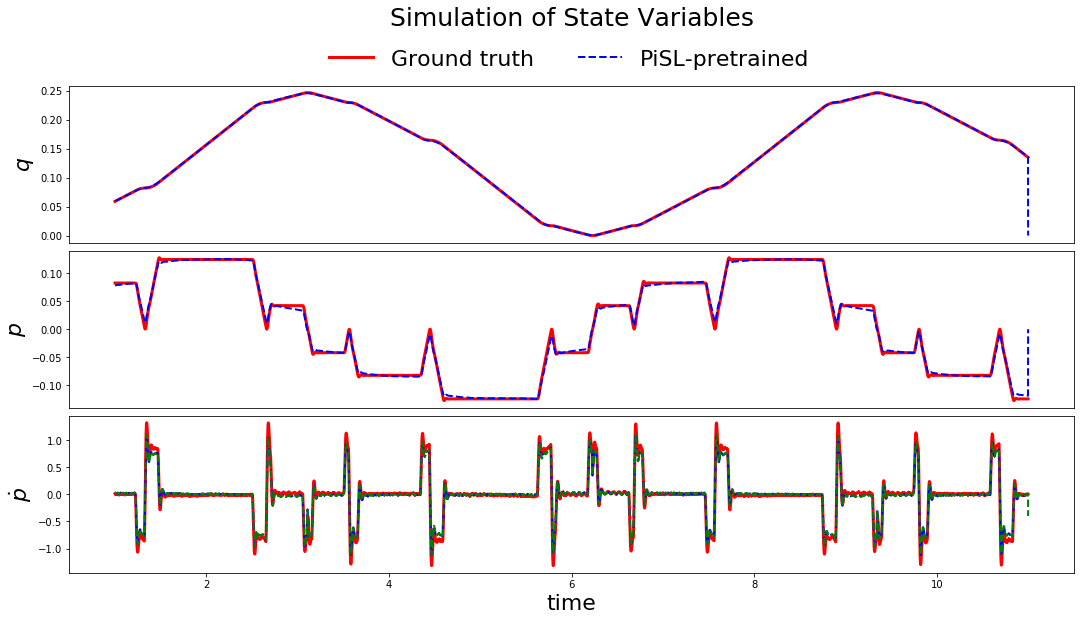

In [7]:
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
p_sfd = sfd._differentiate(q_m, t_m)
dp_sfd = sfd._differentiate(p_sfd, t_m)

fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(411)
ax.set_title("Simulation of State Variables", fontsize=25, pad=60)
ax.plot(t_m, q_m, c='r', lw=3, label='Ground truth')
ax.plot(t_c, np.matmul(basis_c, P.cpu().detach().numpy()[:, 0]), '--', 
         c='b', lw=2, label='PiSL-pretrained')
ax.axes.xaxis.set_visible(False)
ax.set_ylabel('$q$', fontsize=22)
plt.legend(fontsize=22, ncol=2, frameon=False, loc=(0.25,1.05))

ax = fig.add_subplot(412)
ax.plot(t_m, p_sfd, c='r', lw=3, label='Ground truth velocity')
ax.plot(t_c, np.matmul(basis_dt_c, P.cpu().detach().numpy()[:, 0]), '--', 
         c='b', lw=2, label='PiSL-pretrained')
ax.set_ylabel('$p$', fontsize=22)
ax.axes.xaxis.set_visible(False)

f_true = '0.0332*1-0.2124*sign(p)-2.1456*p+0.3683*tau'
q = q_m
p = p_sfd
tau = tau_m
f_sample = eval(f_true)

q = torch.matmul(N_c, P[:, 0])
p = torch.matmul(N_c, P[:, 1])
tau = tau_measurement
f_pretrain = eval(function_dp).cpu().detach().numpy()

ax = fig.add_subplot(413)
ax.plot(t_m, f_sample, c='r', lw=3, label='Ground truth')
ax.plot(t_c, np.matmul(basis_dt_c, P.cpu().detach().numpy()[:, 1]), '--', 
         c='b', lw=2, label='PiSL-pretrained')
ax.plot(t_c, f_pretrain, '--', c='g', lw=2, label='pretrained function')
ax.set_ylabel('$\dot{p}$', fontsize=22)
ax.set_xlabel('time', fontsize=22)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [8]:
# prepare a copy of pre-tuned control points values 
P_pre = P.cpu().detach().numpy().copy()

# convert the pre-tuned equation parameters in matrix form 
lambda_raw = np.zeros(num_term)

function_dp = ''

for i in range(0, num_term):
    term = self_library[i]
    function_dp += (' + '+str(np.round(globals()['c'+str(i)].cpu().detach().numpy()[0], 3))+'*'+term)
    lambda_raw[i] = globals()['c'+str(i)].cpu().detach().numpy()[0]
    
print('p_dot :', function_dp.replace('+ -', '- ')[3:])

p_dot : 0.039*1 - 1.489*p + 0.057*q + 0.941*p**2 - 1.151*q**2 - 0.214*torch.sign(p) + 0.316*tau


ADO - sparsity tuning

In [89]:
loss_HY = []
loss_HY_min = 1000000

terms_HY = [num_term]

A_raw = lambda_raw.copy()
A_raw_HY = A_raw.copy()

P_HY_np = P_pre.copy()
P_HY = torch.autograd.Variable(torch.Tensor(P_HY_np).to(device), requires_grad=True)

diminish_coef = True
num_terms  = np.count_nonzero(A_raw)

tol = 0.01
d_tol = 0.01
lam = 1e-6 # ridge regularizer 
eta = 1e-4 # l-0 penalty ratio
        
tol_best = 0
        
start_time = time.time()

itr = 0

while diminish_coef or itr < 5:
    
    #############################################################################
    ################  ADO part1: refined training of Parameters #################
    
    print('itr:' + str(itr+1))
    print('Training parameters (STRidge):')
    
    
    q = torch.matmul(N_c, P_HY[:, 0]).cpu().detach().numpy()
    p = torch.matmul(N_c, P_HY[:, 1]).cpu().detach().numpy()
    tau = tau_m.flatten()
    
    phi = np.zeros([t_c_len, num_term])
    for i in range(num_term):
        phi[:, i] = eval(self_library[i].replace('torch.', ''))
    phi[:, 0] = phi[:, 0]*0.001
        
    Y_spline = torch.matmul(N_dt, P_HY).cpu().detach().numpy()
    
    A_raw, tol_best = TrainSTRidge(phi, Y_spline[:, 1], lam, eta, d_tol, maxit = 500)
    
    print('best tolerance threshold is', tol_best)
    print('prune number of terms to', np.count_nonzero(A_raw))
    print()
            
            
    #################################################################
    ################  ADO part2: Brute Force traing #################
    
    print('Brute Force training:')
    
    function_dp = ''
    sparse_c_lst = []
    for i in range(0, num_term):
        term = self_library[i]
        if A_raw[i] != 0: 
            function_dp += (' + c'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['c'+str(i)])
    function_dp = function_dp[3:]

    learning_rate = 0.01
    optimizer = torch.optim.Adamax([P_HY] + sparse_c_lst, lr=learning_rate)


    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

    min_loss = 10000
    epochs_no_improve = 0

    loss_his = []

    for t in range(20000):
        optimizer.zero_grad()

        loss = loss_total(P_HY)
        loss.backward()

        scheduler.step(loss)
        loss_his.append(loss.item())

        if loss.item() >= min_loss:
            epochs_no_improve += 1
        else:
            min_loss = loss.item()
            epochs_no_improve = 0

        if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("Early stopping!")
            break

        if t % 5000 == 0:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])

        optimizer.step()

        if t == 19999:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("20,000 epochs completed!")
            
            
    loss_HY.append(loss.item() + eta*np.count_nonzero(A_raw))
    for i in range(num_term): 
        if A_raw[i]!= 0: A_raw[i] = globals()['c'+str(i)].cpu().detach().numpy()[0]

    for i in range(A_raw.shape[0]):
        if abs(A_raw[i]) < tol:
            A_raw[i] = 0
            
    print('prune number of terms to', np.count_nonzero(A_raw))

            
    terms_HY.append(np.count_nonzero(A_raw))
    if loss_HY[-1] < loss_HY_min:
        A_raw_HY = A_raw.copy()
        loss_HY_min = loss_HY[-1]
        
    if np.count_nonzero(A_raw) < num_terms:
        num_terms = np.count_nonzero(A_raw)
    else:
        diminish_coef = False
        
    itr += 1
    print()
    function_dp = ''

    for i in range(0, num_term):
        term = self_library[i]
        if A_raw_HY[i] != 0: function_dp += (' + '+str(np.round(A_raw_HY[i], 4))+'*'+term)

    print('dp/=', function_dp[3:].replace('+ -', '- '))
    print()

    
# print('reach convergence of number of terms in governing equations!')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('final result :')
            
function_dp = ''

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_HY[i] != 0: function_dp += (' + '+str(np.round(A_raw_HY[i], 4))+'*'+term)

print('y/=', function_dp[3:].replace('+ -', '- '))


itr:1
Training parameters (STRidge):
best tolerance threshold is 0.21454909427408309
prune number of terms to 6

Brute Force training:
epoch : 0 loss : 6.969850801397115e-05 lr : 0.01
epoch : 1352 loss : 3.2565053516009357e-06 lr : 0.0001
Early stopping!
prune number of terms to 6

dp/= 0.0182*1 - 2.1608*p + 2.1651*p**2 - 0.1036*q**2 - 0.2115*torch.sign(p) + 0.3683*tau

itr:2
Training parameters (STRidge):
best tolerance threshold is 0.21264931904697473
prune number of terms to 5

Brute Force training:
epoch : 0 loss : 3.4085421702911844e-06 lr : 0.01
epoch : 5000 loss : 2.8495167498476803e-05 lr : 0.0001
epoch : 7672 loss : 3.379875579412328e-06 lr : 0.0001
Early stopping!
prune number of terms to 5

dp/= 0.0121*1 - 2.2764*p + 2.547*p**2 - 0.2003*torch.sign(p) + 0.3694*tau

itr:3
Training parameters (STRidge):
best tolerance threshold is 0.20016982348773887
prune number of terms to 5

Brute Force training:
epoch : 0 loss : 3.379875579412328e-06 lr : 0.01
epoch : 5000 loss : 3.41579288

# baseline: pySINDy

In [10]:
from pysindy import SINDy
from pysindy.feature_library import PolynomialLibrary, CustomLibrary, ConcatLibrary

t = np.around(io.loadmat('../Oscillators/EMPS/DATA_EMPS.mat')['t'], decimals=5, out=None).flatten()
x_sindy = np.hstack([q_m, p_sfd, tau_m])

functions = [lambda q,p,tau: 0.001, 
             lambda q,p,tau: q, 
             lambda q,p,tau: p, 
             lambda q,p,tau: q**2, 
             lambda q,p,tau: p**2, 
             lambda q,p,tau: np.sign(p), 
             lambda q,p,tau: tau]

lib_custom = CustomLibrary(library_functions=functions)
lib_custom.fit(x_sindy)

model = SINDy(feature_names=['q', 'p', 'tau'], feature_library=lib_custom)
model.fit(x_sindy, t[1]-t[0])

def replace(eq):
    f1 = lib_custom.get_feature_names(input_features=['q', 'p', 'tau'])
    f2 = ['0.001', 'p', 'q', 'p**2', 'q**2', 'np.sign(p)', 'tau']
    for i,f in enumerate(f1):
        eq = eq.replace(f, f2[i])
    return eq

sindy_pred = replace(model.equations(3)[1])
sindy_pred = replace(model.equations(3)[1])
sindy_pred = sindy_pred.replace(' + -', '-')
sindy_pred = sindy_pred.replace(' + ', '+')
sindy_pred = sindy_pred.replace(' ', '*')
sindy_pred = sindy_pred.replace('np.', '')
sindy_pred

'19.549*0.001-0.112*p-2.144*q+0.294*p**2+2.547*q**2-0.212*sign(p)+0.368*tau'